In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
!pip install "nltk==3.5"

     |████████████████████████████████| 1.4MB 14.8MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp37-none-any.whl size=1434676 sha256=94afb4b8b422e4216f8ee2f0f28847ef815ebf65d47dcac232ffda88ec499d67
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built nltk
  Found existing installation: nltk 3.6.2
    Uninstalling nltk-3.6.2:
      Successfully uninstalled nltk-3.6.2


In [2]:
from collections import Counter
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import re
from nltk import word_tokenize
import string
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE, Laplace, KneserNeyInterpolated, WittenBellInterpolated
import os
import pickle
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [11]:
df = pd.read_csv('/content/drive/MyDrive/NMT/final_data.csv')

In [12]:
df.head(5)

,text_clean,text_clean_no_accent
0,chây ì nộp phạt nguội,chay i nop phat nguoi
1,cháu đòi tiền cơm dì đòi tiền nhà,chau doi tien com di doi tien nha
2,đà nẵng nghiên cứu tiện ích nhắn tin khi vi ph...,da nang nghien cuu tien ich nhan tin khi vi ph...
3,khó xử vụ mẹ tuổi trộm xe hơi của con gái,kho xu vu me tuoi trom xe hoi cua con gai
4,thay đổi về đăng ký chuyển nhượng xe từ bạn cầ...,thay doi ve dang ky chuyen nhuong xe tu ban ca...


In [5]:
def tokenize(s):
  return s.split(" ")

In [13]:
df_train = df.iloc[:100000, :]
df_test = df.iloc[-1000:, :]
df_train.shape, df_test.shape

((100000, 2), (1000, 2))

In [7]:
sents = df_train.text_clean.to_list()

In [8]:
corpus = []
for sent in tqdm(sents, position=0, leave=True):
  corpus.append(tokenize(sent))

100%|██████████| 100000/100000 [00:00<00:00, 259429.88it/s]


In [11]:
n = 3
train_data, padded_sents = padded_everygram_pipeline(n, corpus)

In [12]:
%%time
vi_model = KneserNeyInterpolated(n)
vi_model.fit(train_data, padded_sents)

CPU times: user 36.5 s, sys: 277 ms, total: 36.8 s
Wall time: 36.7 s


In [43]:
model_dir = "/content/drive/My Drive/Colab Notebooks/Ngram_model"
with open(os.path.join(model_dir, 'kneserney_1st_ngram_model.pkl'), 'wb') as fout:
    pickle.dump(vi_model, fout)

In [9]:
!wget -O vn_syllables.txt "https://gist.githubusercontent.com/hieuthi/0f5adb7d3f79e7fb67e0e499004bf558/raw/135a4d9716e49a981624474156d6f247b9b46f6a/all-vietnamese-syllables.txt"

--2021-05-27 04:53:21--  https://gist.githubusercontent.com/hieuthi/0f5adb7d3f79e7fb67e0e499004bf558/raw/135a4d9716e49a981624474156d6f247b9b46f6a/all-vietnamese-syllables.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116290 (114K) [text/plain]
Saving to: ‘vn_syllables.txt’

vn_syllables.txt    100%[===================>] 113.56K  --.-KB/s    in 0.008s  

2021-05-27 04:53:21 (14.1 MB/s) - ‘vn_syllables.txt’ saved [116290/116290]



In [5]:
def remove_vn_accent(word):
    word = re.sub('[áàảãạăắằẳẵặâấầẩẫậ]', 'a', word)
    word = re.sub('[éèẻẽẹêếềểễệ]', 'e', word)
    word = re.sub('[óòỏõọôốồổỗộơớờởỡợ]', 'o', word)
    word = re.sub('[íìỉĩị]', 'i', word)
    word = re.sub('[úùủũụưứừửữự]', 'u', word)
    word = re.sub('[ýỳỷỹỵ]', 'y', word)
    word = re.sub('đ', 'd', word)
    return word

def gen_accents_word(word):
    word_no_accent = remove_vn_accent(word.lower())
    all_accent_word = {word}
    for w in open('vn_syllables.txt').read().splitlines():
        w_no_accent = remove_vn_accent(w.lower())
        if w_no_accent == word_no_accent:
            all_accent_word.add(w)
    return all_accent_word


In [4]:
# beam search
def beam_search(words, model, k=3):
  sequences = []
  for idx, word in enumerate(words):
    if idx == 0:
      sequences = [([x], 0.0) for x in gen_accents_word(word)]
    else:
      all_sequences = []
      for seq in sequences:
        for next_word in gen_accents_word(word):
          current_word = seq[0][-1]
          try:
              previous_word = seq[0][-2]
              score = model.logscore(next_word, [previous_word, current_word])
          except:
              score = model.logscore(next_word, [current_word])
          new_seq = seq[0].copy()
          new_seq.append(next_word)
          all_sequences.append((new_seq, seq[1] + score))
      all_sequences = sorted(all_sequences,key=lambda x: x[1], reverse=True)
      sequences = all_sequences[:k]
  return sequences

In [3]:
import os
import pickle

model_dir = "/content/drive/My Drive/Colab Notebooks/Ngram_model"
with open(os.path.join(model_dir, 'kneserney_1st_ngram_model.pkl'), 'rb') as fin:
    model_loaded = pickle.load(fin)

# print(len(model_loaded.vocab))

In [14]:
model_loaded.vocab.unk_label

'<UNK>'

In [6]:
# cháu đòi tiền
model_loaded.logscore("tiền", ["á", "đòi"])

-3.869823092066273

In [8]:
detokenize = TreebankWordDetokenizer().detokenize
sentence = "ngay hom qua la ngay bau cư tong thong My"
result = beam_search(sentence.lower().split(), model_loaded)
print(detokenize(result[0][0]))

ngày hôm qua là ngày bầu cử tổng thống mỹ


# Evaluation

In [9]:
def inference(sentence):
  result = beam_search(sentence.lower().split(), model_loaded)
  s_result = detokenize(result[0][0])
  if len(s_result) > 0:
    return s_result
  return ''

In [14]:
inference("tram nam roi lai ra di")

'trăm năm rồi lái ra đi'

In [15]:
%%time
df_test['predict'] = df_test.text_clean_no_accent.apply(inference)

CPU times: user 2h 15min 50s, sys: 20.5 s, total: 2h 16min 11s
Wall time: 2h 16min 15s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
def sentence_accuracy(row):
  src = row.text_clean.split(" ")
  predict = row.predict.split(" ")
  t = 0
  for i in range(min(len(src), len(predict))):
    if (src[i] == predict[i]):
      t += 1
  return t/len(src)

In [18]:
%%time
df_test['accuracy'] = df_test.apply(sentence_accuracy, axis=1)

CPU times: user 33.4 ms, sys: 1 µs, total: 33.4 ms
Wall time: 34.4 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
df_test.accuracy.mean()

0.7228009544158676

(array([ 10.,   0.,   6.,   6.,   9.,  19.,  12.,  23.,  33.,  19.,  69.,
         69.,  62.,  85.,  60.,  84., 111.,  71.,  80., 172.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

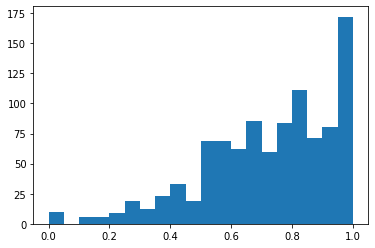

In [20]:
plt.hist(df_test.accuracy, bins=20)